# Data exploration with Boston Bikeshare csvs

In [1]:
import pandas as pd
import glob
import os

In [9]:
def readDir():
    """
    Returns a dataframe of the data files in the directory with the bikeshare data.
    """
    data = pd.DataFrame()
    
    path = os.path.join(os.sep, "raid", "public_data", "Bike_Share_Data", "Boston")
    
    for filename in glob.glob(os.path.join(path, '*.csv')):
        # Get the filesizes in megabytes
        f_size = os.path.getsize(filename) / 1_000_000
        
        # A dictionary stores information about the files to be be put in the df
        file = {"Filename": filename, "Size (mb)": f_size}
        data = data.append(file, ignore_index=True)
        
    return data

def openCSV(files, index):
    """
    Using filenames retrieved with readDir, use this function to open a specific
    csv. Returns a dataframe with the data requested.
    """
    data = pd.read_csv(files.loc[index, 'Filename'])
    if index != 0:
        data['starttime'] = pd.to_datetime(data['starttime'])
        data['stoptime'] = pd.to_datetime(data['stoptime'])
    return data
    

In [3]:
files = readDir()

In [19]:
files

,Filename,Size (mb)
0,/raid/public_data/Bike_Share_Data/Boston/Hubwa...,0.014625
1,/raid/public_data/Bike_Share_Data/Boston/20170...,3.949912
2,/raid/public_data/Bike_Share_Data/Boston/20170...,7.013439
3,/raid/public_data/Bike_Share_Data/Boston/20170...,22.474458
4,/raid/public_data/Bike_Share_Data/Boston/20170...,28.713518
5,/raid/public_data/Bike_Share_Data/Boston/20150...,1.812700
6,/raid/public_data/Bike_Share_Data/Boston/20150...,0.928194
7,/raid/public_data/Bike_Share_Data/Boston/20150...,2.623164
8,/raid/public_data/Bike_Share_Data/Boston/20150...,12.199585
9,/raid/public_data/Bike_Share_Data/Boston/20150...,31.903472


In [18]:
df = openCSV(files, 49)

# df

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,371,2019-01-01 00:09:13.798,2019-01-01 00:15:25.336,80,MIT Stata Center at Vassar St / Main St,42.362131,-71.091156,179,MIT Vassar St,42.355601,-71.103945,3689,Subscriber,1987,1
1,264,2019-01-01 00:33:56.182,2019-01-01 00:38:20.880,117,Binney St / Sixth St,42.366162,-71.086883,189,Kendall T,42.362428,-71.084955,4142,Subscriber,1990,1
2,458,2019-01-01 00:41:54.600,2019-01-01 00:49:33.273,68,Central Square at Mass Ave / Essex St,42.365070,-71.103100,96,Cambridge Main Library at Broadway / Trowbridg...,42.373379,-71.111075,1628,Subscriber,1977,1
3,364,2019-01-01 00:43:32.571,2019-01-01 00:49:37.426,89,Harvard Law School at Mass Ave / Jarvis St,42.379011,-71.119945,334,Mass Ave at Hadley/Walden,42.391210,-71.122608,2969,Subscriber,1993,1
4,681,2019-01-01 00:49:56.464,2019-01-01 01:01:17.701,73,Harvard Square at Brattle St / Eliot St,42.373231,-71.120886,367,Vassal Lane at Tobin/VLUS,42.383932,-71.139613,3469,Subscriber,1979,2
5,549,2019-01-01 00:50:01.037,2019-01-01 00:59:10.319,104,Harvard University Radcliffe Quadrangle at She...,42.380287,-71.125107,76,Central Sq Post Office / Cambridge City Hall a...,42.366426,-71.105495,4050,Customer,1969,0
6,304,2019-01-01 00:54:48.931,2019-01-01 00:59:53.581,80,MIT Stata Center at Vassar St / Main St,42.362131,-71.091156,179,MIT Vassar St,42.355601,-71.103945,3861,Subscriber,1991,1
7,425,2019-01-01 01:00:48.062,2019-01-01 01:07:53.396,4,Tremont St at E Berkeley St,42.345392,-71.069616,46,Christian Science Plaza - Massachusetts Ave at...,42.343666,-71.085824,3571,Subscriber,1993,1
8,1353,2019-01-01 01:03:34.412,2019-01-01 01:26:07.852,91,One Kendall Square at Hampshire St / Portland St,42.366277,-71.091690,78,Union Square - Somerville,42.379595,-71.095308,3066,Customer,1989,1
9,454,2019-01-01 01:08:56.124,2019-01-01 01:16:30.324,36,Copley Square - Dartmouth St at Boylston St,42.349935,-71.077386,39,Washington St at Rutland St,42.338515,-71.074041,3443,Subscriber,1973,1


In [32]:
def usePerMonth(files_df):
    """
    Takes the dataframe of files and returns a new dataframe of files with rides per calendar month.
    """
    resdf = pd.DataFrame()
    
    for i in range(1, files_df.index.values.shape[0]):
        df = openCSV(files_df, i)
        resdf = resdf.append({'Date': df.loc[0, 'starttime'], 'Rides': df.index.values.shape[0]}, ignore_index=True)
        
    return resdf

In [33]:
df = usePerMonth(files)

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

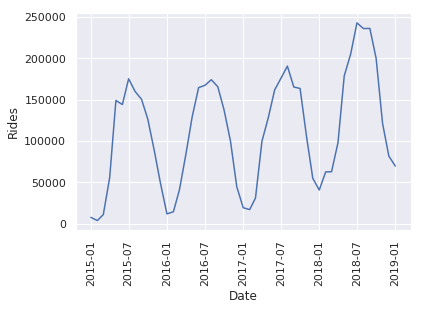

In [37]:
sns.set()

sns.lineplot(x='Date', y='Rides', data=df)
plt.xticks(rotation=90);